In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import time

from sklearn.model_selection import train_test_split

In [2]:
def dcg_at_k(y, k):
    idx = 2
    cumul = y[0]
    for score in y[1:k]:
        cumul += score / np.log2(idx)
        idx += 1
    return cumul

In [3]:
def ndcg_at_k(y_ts, X_ts, ranker, k=10):
    # predict relevance of test set and merge with true relevance
    y_pred = ranker.predict(X_ts.drop(columns=['qid']))
    y_merged = pd.concat([y_ts, pd.Series(y_pred)], axis=1)
    y_merged.columns = ['qid', 'score_true', 'score_pred']

    # sort by score_pred, calculate DCG@K
    y_merged = y_merged.sort_values(by=['qid', 'score_pred'], ascending=[True, False])

    # calculate DCG@K for each query
    dcg = y_merged.groupby('qid').apply(lambda x: dcg_at_k(x['score_true'].values, k), include_groups=False)

    # calulate IDCG@K for each query
    idcg = y_merged.groupby('qid').apply(lambda x: dcg_at_k(sorted(x['score_true'].values, reverse=True), k), include_groups=False)

    return dcg / idcg

In [4]:
# Yahoo LtR challenge
def parser(filename, length):
    with open(filename, 'r') as f:
        rel_scores = []
        qids = []
        features = {}
        counter = 0
        for line in f:
            data = line.split()
            rel_scores.append(int(data[0]))
            qids.append(int(data[1].split(':')[1]))

            for pair in data[2:]:
                col, val = pair.split(':')
                col = int(col)
                val = float(val)

                if col not in features:
                    features[col] = [0.0] * (len(rel_scores)-1)
                features[col].append(val)
            
            for i in range(max(features.keys()) + 1):
                if i not in features.keys():
                    features[i] = [0.0] * len(rel_scores)
                if len(features[i]) < len(rel_scores):
                    features[i].extend([0.0] * (len(rel_scores) - len(features[i])))

            counter += 1
            if counter == length:
                break
    
    features['score'] = rel_scores
    features['qid'] = qids

    return pd.DataFrame(data=features)

In [5]:
yahoo_train = parser('../datasets/Yahoo/ltrc_yahoo/set1.train.txt', 400000)
yahoo_test = parser('../datasets/Yahoo/ltrc_yahoo/set1.test.txt', 20000)

In [6]:
X_tr, y_tr = yahoo_train.drop(columns=['score']), yahoo_train[['qid', 'score']]
X_ts, y_ts = yahoo_test.drop(columns=['score']), yahoo_test[['qid', 'score']]

train_qids = X_tr['qid']
test_qids = X_ts['qid']

# Order the columns in the same way
X_tr = X_tr.reindex(sorted(X_tr.drop(columns=['qid']).columns), axis=1)
X_tr['qid'] = train_qids
X_ts = X_ts.reindex(sorted(X_ts.drop(columns=['qid']).columns), axis=1)
X_ts['qid'] = test_qids

## Speed + ndcg

In [7]:
ranker = xgb.XGBRanker(n_estimators=500,
                       n_jobs=-1,
                       tree_method='exact',
                       max_depth=8,
                       learning_rate=0.1,
                       objective='rank:ndcg')

start = time.time()
ranker.fit(X_tr.drop(columns=['qid']),
           y_tr.drop(columns=['qid']),
           qid=X_tr['qid']
           )
end = time.time()

print((end - start) / 500)

5.823434811592102


In [8]:
ndcg_at_k(y_ts, X_ts, ranker).mean()

np.float64(0.7889742297824517)

In [9]:
ranker = xgb.XGBRanker(n_estimators=500,
                       n_jobs=-1,
                       tree_method='exact',
                       max_depth=8,
                       learning_rate=0.1,
                       colsample_bytree=0.5,
                       objective='rank:ndcg')

start = time.time()
ranker.fit(X_tr.drop(columns=['qid']),
           y_tr.drop(columns=['qid']),
           qid=X_tr['qid']
           )
end = time.time()

print((end - start) / 500)

3.1791823363304137


In [10]:
ndcg_at_k(y_ts, X_ts, ranker).mean()

np.float64(0.7866859924223751)

## Changing thread number

In [7]:
X_tr = X_tr[:10000]
y_tr = y_tr[:10000]

In [16]:
times = []
for nthreads in [1,2,4,8,16]:
    ranker = xgb.XGBRanker(n_estimators=500,
                           n_jobs=nthreads,
                           tree_method='exact',
                           max_depth=8,
                           learning_rate=0.1,
                           objective='rank:ndcg')

    start = time.time()
    ranker.fit(
        X_tr.drop(columns=['qid']),
        y_tr.drop(columns=['qid']),
        qid=X_tr['qid']
        )
    end = time.time()

    per_tree = (end - start) / 500
    times.append(per_tree)

In [17]:
import matplotlib.pyplot as plt

In [18]:
# convert times to ms for better readability
times = [t * 1000 for t in times]

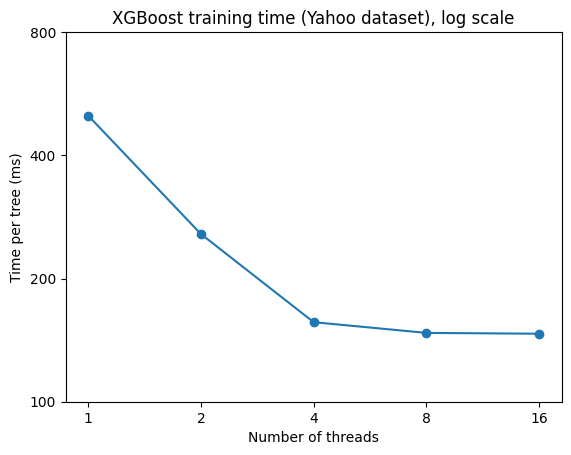

In [26]:
plt.plot([1,2,4,8,16], times, marker='o')
plt.xlabel('Number of threads')
plt.ylabel('Time per tree (ms)')

plt.xscale('log', base=2)
plt.yscale('log', base=2)

plt.xticks([1,2,4,8,16], [1,2,4,8,16])
plt.yticks([100, 200, 400, 800], [100, 200, 400, 800])

plt.title('XGBoost training time (Yahoo dataset), log scale')
plt.savefig('../figs/yahoo_threads_log.png', dpi=300, bbox_inches='tight')
plt.show()

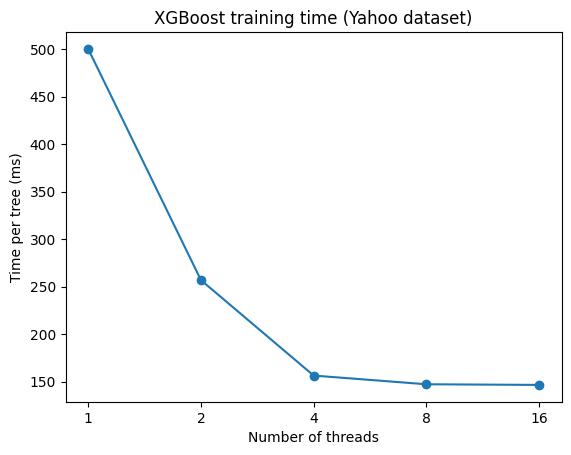

In [30]:
plt.plot([1,2,4,8,16], times, marker='o')
plt.xlabel('Number of threads')
plt.ylabel('Time per tree (ms)')

plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16], [1,2,4,8,16])

plt.title('XGBoost training time (Yahoo dataset)')
plt.savefig('../figs/yahoo_threads.png', dpi=300, bbox_inches='tight')
plt.show()